# 1 Setup

## 1.1 Import some great packages


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from base import ROOT_DIR
from tqdm.notebook import tqdm

## 1.2 Load the data

In [2]:
# set paths of different subdirectories
dir_eaglebine = ROOT_DIR / 'gtx/data/Eaglebine/Eaglebine'
dir_duvernay = ROOT_DIR / 'gtx/data/Duvernay/Duvernay/'

# 2 Organize Eaglebine temperature data

## 2.1 read in BHT

In [3]:
Eaglebine_BHT = pd.read_excel(dir_eaglebine / 'Eaglebine BHT TSC data for SPE April 21 2020.xlsx')
Eaglebine_BHT['TempC_BHT'] = (Eaglebine_BHT['BHTorMRT (maximum recorded temperature) oF'] - 32) * (5./9.)
Eaglebine_BHT.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889


In [4]:
print("number of unique wells: " + str(len(pd.unique(Eaglebine_BHT['UWI']))))

number of unique wells: 324


## 2.2 Read in Eaglebine synthetic "true formation temperature"

In [5]:
Eaglebine_Truth = pd.read_excel(dir_eaglebine / 'Eaglebine TrueTemp_Train2.xlsx')
Eaglebine_Truth.head()

,UWI,Depth sub-sea (feet),True Temperature (oF)
0,42013301410000,-350,70.33
1,42013301410000,-300,70.33
2,42013301410000,-250,70.33
3,42013301410000,-200,71.49
4,42013301410000,-150,72.66


In [6]:
# convert to Celsius
Eaglebine_Truth['TempTrue_degC'] = (Eaglebine_Truth['True Temperature   (oF)'] - 32) * (5./9.)

In [7]:
print("number of unique wells in Eaglebine in training set: " + str(len(pd.unique(Eaglebine_Truth['UWI']))))

number of unique wells in Eaglebine in training set: 243


## 2.3 Combine measured BHT and true temperature

In [8]:
Eaglebine_Combined = Eaglebine_BHT.merge(Eaglebine_Truth, on='UWI', how='left')

In [9]:
# only keep from the synthetic data, the temperature at the elevation closest to the model
Eaglebine_Combined['diff_depth'] = Eaglebine_Combined['Depth sub-sea (feet)']-Eaglebine_Combined['BHT_below sea level (ft)']
Eaglebine_Combined['diff_depth_abs'] = np.abs(Eaglebine_Combined['diff_depth'])
idx = Eaglebine_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Eaglebine_Combined['diff_depth_abs']
TrueTempUWI = Eaglebine_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'TempTrue_degC']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Eaglebine_Combined_cln = Eaglebine_BHT.merge(TrueTempUWI, on='UWI', how='left')
Eaglebine_Combined_cln.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,diff_depth_abs,TempTrue_degC
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,22.50,141.555556
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,4.00,132.038889
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,17.00,89.161111
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,6.00,107.961111
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,9.48,133.722222


In [10]:
len(Eaglebine_Combined_cln)

324

## 2.4 Read in static temperature information and merge into dataset

In [11]:
Static_log_temp = pd.read_csv(ROOT_DIR / 'gtx/data/Data_static_logs.csv')
Static_log_temp.head()

,Well_ID,Depth (ft),Temp (degC),Field
0,42013301930000,10700.0,132.778000,Eaglebine
1,42041305800000,7360.0,82.777778,Eaglebine
2,42041311700000,7828.0,118.888889,Eaglebine
3,42041311980000,7954.0,105.000000,Eaglebine
4,42051305380000,8380.0,111.111111,Eaglebine


In [12]:
Eaglebine_Combined_cln['UWI'] = Eaglebine_Combined_cln['UWI'].astype(str)
Eaglebine_Combined_cln = Eaglebine_Combined_cln.copy(deep=True)
Eaglebine_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Eaglebine_Combined_stat = Eaglebine_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [13]:
# Coalesce columns together with priority for true temperature measurements
Eaglebine_Combined_stat['TempC_Fin'] = Eaglebine_Combined_stat['Temp (degC)'].fillna(Eaglebine_Combined_stat['TempTrue_degC'])
Eaglebine_Combined_stat['TrueTemp_datasource'] = Eaglebine_Combined_stat['TrueTemp_datasource_stat'].fillna(Eaglebine_Combined_stat['TrueTemp_datasource_syn'])
Eaglebine_Combined_stat.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,diff_depth_abs,TempTrue_degC,TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,22.50,141.555556,synthetic,NaN,NaN,NaN,NaN,NaN,141.555556,synthetic
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,4.00,132.038889,synthetic,42013301930000,10700.0,132.778,Eaglebine,static_temp_logs,132.778000,static_temp_logs
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,17.00,89.161111,synthetic,NaN,NaN,NaN,NaN,NaN,89.161111,synthetic
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,6.00,107.961111,synthetic,NaN,NaN,NaN,NaN,NaN,107.961111,synthetic
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,9.48,133.722222,synthetic,NaN,NaN,NaN,NaN,NaN,133.722222,synthetic


## 2.5 plot the eaglebine temperature data

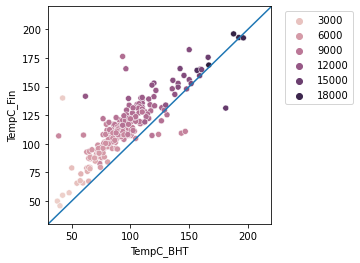

In [14]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Eaglebine_Combined_stat, x="TempC_BHT", y="TempC_Fin", hue='BHT_below sea level (ft)', ax=ax)

ax.set_xlim([30, 220])
ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 3 Organize Duvernay temperature data

## 3.1 Read in DST BHT input and "true temp" synthetic data

In [15]:
Duvernay_Truth = pd.read_excel(dir_duvernay / 'Duvenay TrueTemp_Train.xlsx')
Duvernay_DST = pd.read_excel(dir_duvernay / 'Duvernay DST BHT for SPE April 20 2021.xlsx')
Duvernay_Truth.head()

,UWI,Depths subsea (m),True Temperature (oC)
0,100010107020W500,-720,2.53
1,100010107020W500,-700,2.54
2,100010107020W500,-680,2.54
3,100010107020W500,-660,3.30
4,100010107020W500,-640,4.06


In [16]:
# add in an extra column calculating the depth sub sea (elevation-depth)*-1 
Duvernay_DST['Depth_SS(m)']=-1*(Duvernay_DST['elevation M above sea level']-(Duvernay_DST['DST Start Depth (MD) (m)']+Duvernay_DST['DST End Depth (MD) (m)'])/2)
Duvernay_DST.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m)
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,645.6,100010608109W500,1044.4
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,1283.8,100010904012W500,2424.2
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,651.6,100011206021W400,171.9
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,873.1,100011506915W500,936.4


In [17]:
# merge
Duvernay_Combined = Duvernay_DST.merge(Duvernay_Truth, on='UWI', how='left')
Duvernay_Combined.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m),Depths subsea (m),True Temperature (oC)
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-720.0,2.53
1,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-700.0,2.54
2,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-680.0,2.54
3,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-660.0,3.30
4,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-640.0,4.06


In [18]:
# keep only the synthetic model temperature data for the relevant depths for which there is BHT measurement
Duvernay_Combined['diff_depth'] = Duvernay_Combined['Depth_SS(m)']-Duvernay_Combined['Depths subsea (m)']
Duvernay_Combined['diff_depth_abs'] = np.abs(Duvernay_Combined['diff_depth'])
idx = Duvernay_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Duvernay_Combined['diff_depth_abs']

TrueTempUWI = Duvernay_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'True Temperature (oC)']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Duvernay_Combined_cln = Duvernay_DST.merge(TrueTempUWI, on='UWI', how='left')
Duvernay_Combined_cln = Duvernay_Combined_cln.drop_duplicates(['UWI'])
Duvernay_Combined_cln.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m),diff_depth_abs,True Temperature (oC)
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,4.0,60.97
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,645.6,100010608109W500,1044.4,4.4,63.98
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,1283.8,100010904012W500,2424.2,NaN,NaN
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,651.6,100011206021W400,171.9,8.1,39.07
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,873.1,100011506915W500,936.4,3.6,69.47


In [19]:
len(Duvernay_Combined_cln)

512

## 3.2 Merge in static temperature log data

In [20]:
Duvernay_Combined_cln['UWI'] = Duvernay_Combined_cln['UWI'].astype(str)
Duvernay_Combined_cln = Duvernay_Combined_cln.copy(deep=True)
Duvernay_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Duvernay_Combined_stat = Duvernay_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [21]:
Static_log_temp.head()

,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat
0,42013301930000,10700.0,132.778000,Eaglebine,static_temp_logs
1,42041305800000,7360.0,82.777778,Eaglebine,static_temp_logs
2,42041311700000,7828.0,118.888889,Eaglebine,static_temp_logs
3,42041311980000,7954.0,105.000000,Eaglebine,static_temp_logs
4,42051305380000,8380.0,111.111111,Eaglebine,static_temp_logs


In [22]:
# Coalesce columns together with priority for true temperature measurements
Duvernay_Combined_stat['TempC_Fin'] = Duvernay_Combined_stat['Temp (degC)'].fillna(Duvernay_Combined_stat['True Temperature (oC)'])
Duvernay_Combined_stat['TrueTemp_datasource'] = Duvernay_Combined_stat['TrueTemp_datasource_stat'].fillna(Duvernay_Combined_stat['TrueTemp_datasource_syn'])

Duvernay_Combined_stat.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,...,diff_depth_abs,True Temperature (oC),TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,...,4.0,60.97,synthetic,NaN,NaN,NaN,NaN,NaN,60.97,synthetic
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,...,4.4,63.98,synthetic,NaN,NaN,NaN,NaN,NaN,63.98,synthetic
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,...,NaN,NaN,synthetic,NaN,NaN,NaN,NaN,NaN,NaN,synthetic
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,...,8.1,39.07,synthetic,NaN,NaN,NaN,NaN,NaN,39.07,synthetic
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,...,3.6,69.47,synthetic,NaN,NaN,NaN,NaN,NaN,69.47,synthetic


## 3.3 Plot the temp data

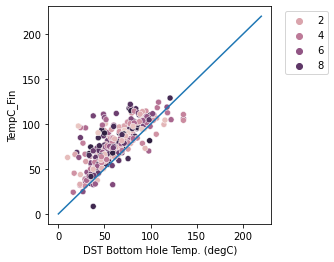

In [23]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Duvernay_Combined_stat, 
                x="DST Bottom Hole Temp. (degC)",
                y="TempC_Fin",
                hue='diff_depth_abs', ax=ax)

#ax.set_xlim([30, 220])
#ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 4 Combine Eaglebine and Duvernay temperature datasets

In [24]:
Duvernay = Duvernay_Combined_stat[['UWI', 'DST Bottom Hole Temp. (degC)', 'TempC_Fin','Depth_SS(m)']]
Duvernay = Duvernay.rename(columns={'DST Bottom Hole Temp. (degC)': 'BHT', 'TempC_Fin': 'TrueTemp'})
Duvernay['Field'] = 'Duvernay'

Eaglebine = Eaglebine_Combined_stat[['UWI', 'TempC_BHT', 'TempC_Fin', 'TD (ft)']]
Eaglebine = Eaglebine.rename(columns={'TempC_BHT': 'BHT', 'TempC_Fin': 'TrueTemp'})
Eaglebine['Field'] = 'Eaglebine'

combined_temperature = pd.concat((Duvernay, Eaglebine))
combined_temperature.head()

,UWI,BHT,TrueTemp,Depth_SS(m),Field,TD (ft)
0,100010107020W500,48.33,60.97,716.0,Duvernay,NaN
1,100010608109W500,34.26,63.98,1044.4,Duvernay,NaN
2,100010904012W500,104.40,NaN,2424.2,Duvernay,NaN
3,100011206021W400,29.00,39.07,171.9,Duvernay,NaN
4,100011506915W500,64.00,69.47,936.4,Duvernay,NaN


In [25]:
# save this structured data to file
! mkdir StructuredData
combined_temperature.to_csv('StructuredData/combined_temperature.csv')

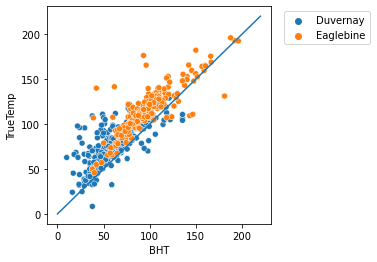

In [26]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=combined_temperature, 
                x="BHT",
                y="TrueTemp",
                hue='Field', ax=ax)

ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## 4.1 TVD Vs Temperatures (Eaglebine & Duvernay Basins)

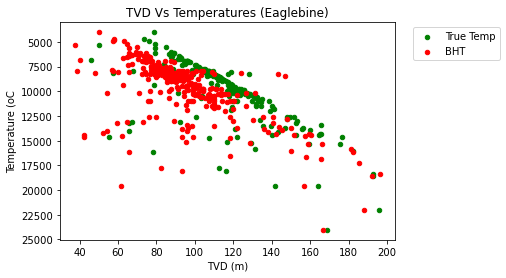

In [27]:
fig, ax1 = plt.subplots(sharex=True)
combined_temperature.plot.scatter(x='TrueTemp', y='TD (ft)', c='green', ax=ax1, label='True Temp')
combined_temperature.plot.scatter(x='BHT', y='TD (ft)', c='red', ax=ax1, label='BHT')
ax1.invert_yaxis()
ax1.set_xlabel('TVD (m)')
ax1.set_ylabel('Temperature (oC')
ax1.set_title('TVD Vs Temperatures (Eaglebine)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

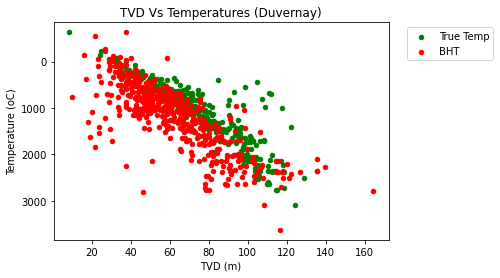

In [28]:
fig, ax2 = plt.subplots(sharex=True)
combined_temperature.plot.scatter(x='TrueTemp', y='Depth_SS(m)', c='green', ax=ax2, label='True Temp')
combined_temperature.plot.scatter(x='BHT', y='Depth_SS(m)', c='red', ax=ax2, label='BHT')
ax2.invert_yaxis()
ax2.set_xlabel('TVD (m)')
ax2.set_ylabel('Temperature (oC)')
ax2.set_title('TVD Vs Temperatures (Duvernay)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

